In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import sklearn.preprocessing
import torch
import torchvision
import torchvision.datasets
import torchvision.models
import torchvision.transforms

In [2]:
numeros = sklearn.datasets.load_digits()
imagenes = numeros['images']  # Hay 1797 digitos representados en imagenes 8x8
n_imagenes = len(imagenes)
X = imagenes.copy()
Y = numeros['target']
print(np.shape(X))

(1797, 8, 8)


In [3]:
inputs = torch.autograd.Variable(torch.Tensor(X).float()).unsqueeze(1)
print(inputs.size())

torch.Size([1797, 1, 8, 8])


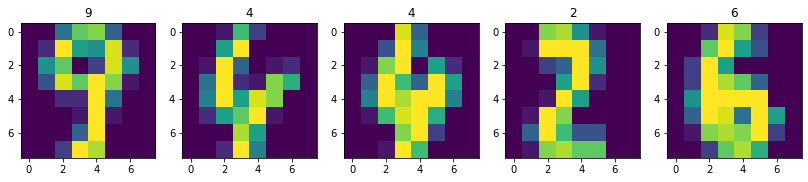

In [4]:
# muestra algunos ejemplos

n_items = inputs.data.size()[0]
random_items = np.random.choice(np.arange(n_items), 5)

plt.figure(figsize=(14,5))
for i in range(5):
    plt.subplot(1,5,i+1)
    item  = random_items[i]
    plt.imshow(inputs[item][0].detach().numpy())
    plt.title(Y[item])

In [5]:
# normaliza
mean = inputs.mean(dim=0)
std = inputs.std(dim=0)
std[std==0]=1.0

for i in range(len(inputs)):
    inputs[i] = (inputs[i])/std
np.shape(inputs)


torch.Size([1797, 1, 8, 8])

# define el autoencoder
Variamos los parámetrosk1,k2,k3 con k3: espacio latente

In [6]:

class Autoencoder(torch.nn.Module):
    def __init__(self,k1, k2, k3):
        super(Autoencoder,self).__init__()
        #k1=16; k2=8; k3=4
        self.k1=k1
        self.k2=k2
        self.k3=k3
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, k1, kernel_size=3),
            torch.nn.Conv2d(k1,k2,kernel_size=3),
            torch.nn.Conv2d(k2,k3,kernel_size=3))
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(k3,k2,kernel_size=3),
            torch.nn.ConvTranspose2d(k2,k1,kernel_size=3),
            torch.nn.ConvTranspose2d(k1,1,kernel_size=3))
    def forward(self,x,k1, k2, k3):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
# entrenamiento
# inicializa modelo, loss y optimizador
k1=16
k2_tot=[4,8,12]
#k3=4
latent_space=np.linspace(2.,12.,6)
n_c_tot=[]
loss_tot=[]
for k2 in k2_tot:
    for k3 in latent_space:
        num_epochs = 100
        model = Autoencoder(k1,int(k2),int(k3))
        print(model)
        distance = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1E-4)
        loss_list = [] 
        for epoch in range(num_epochs):
            output = model(inputs,k1,8,4)
            loss = distance(output, inputs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_list.append(loss.item())
            #print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))
        loss_tot.append(loss_list[-1])
        #type(loss.item())
        n_c=0
        for m in model.parameters():
            n_c+=m.flatten().size()[0]
        n_c_tot.append(n_c)
        print(n_c)


Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1))
    (2): Conv2d(4, 2, kernel_size=(3, 3), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(2, 4, kernel_size=(3, 3), stride=(1, 1))
    (1): ConvTranspose2d(4, 16, kernel_size=(3, 3), stride=(1, 1))
    (2): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1))
  )
)
1627
Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1))
    (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(4, 4, kernel_size=(3, 3), stride=(1, 1))
    (1): ConvTranspose2d(4, 16, kernel_size=(3, 3), stride=(1, 1))
    (2): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1))
  )
)
1773
Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  

In [9]:
loss_tot_2=np.reshape(loss_tot,(len(k2_tot),len(latent_space)))
n_c_2=np.reshape(n_c_tot,(len(k2_tot),len(latent_space)))

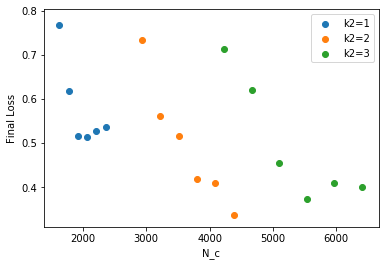

In [10]:
for i in range(len(k2_tot)):
    plt.scatter(n_c_2[i],loss_tot_2[i],label="k2={}".format(i+1))
plt.xlabel("N_c")
plt.ylabel("Final Loss")
plt.legend()

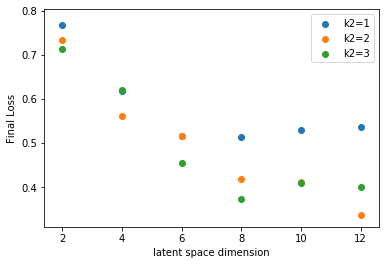

In [11]:

for i in range(len(k2_tot)):
    plt.scatter(latent_space,loss_tot_2[i],label="k2={}".format(i+1))
plt.xlabel("latent space dimension")
plt.ylabel("Final Loss")
plt.legend()

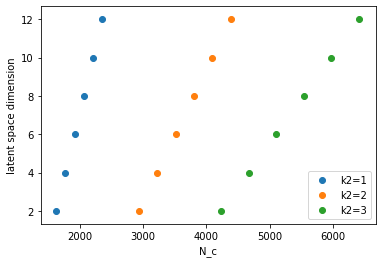

In [12]:

for i in range(len(k2_tot)):
    plt.scatter(n_c_2[i],latent_space,label="k2={}".format(i+1))
plt.xlabel("N_c")
plt.ylabel("latent space dimension")
plt.legend()

# Discusión
* En la primera gráfica se muestra la pérdida final (para la última iteración de épocas) versus el número de parámetros. Es posible ver que al aumentar el número de parámetros, para una dimensión de la capa intermedia k2 constante, hace que la pérdida diminuya. Además si aumentamos la dimensionalidad de k2 ocurre un corrimiento de la gráfica, es decir, se aumenta el número de parámetros pero la pérdida sigue siendo la misma.
* En la segunda gráfica se muestra la pérdida final ("loss") versus la dimensión del espacio latente. Se observa que al aumentar la dimensión del espacio latente disminuye el "loss" y que la convergencia hacia un valor mínimo de loss mejora cuando aumentamos el número la dimensionalidad de la capa intermedia k2, la cual es la dimensión de salida de la primera convolución y es la dimensión de entrada de la segunda convolución.